# Pylops - basic linear operators

### Author: M.Ravasi

In this notebook I will show how to use some of the basic linear operators implemented in *Pylops*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import IRLS as IRLSpylops
from pylops.optimization.sparsity  import FISTA, SPGL1

# Overloading scipy linear operator

To start we show how to use scipy LinearOperator object and its built-in operations (forward and adjoint matrix-vector multiplication)

In [2]:
def mv(v):
    return np.array([1,1,1])

def rmv(v):
    return np.array([2,2])

# define linear operator
A = spLinearOperator((3,2), matvec=mv, rmatvec=rmv, dtype=None)
# define adjoint operator
B = A.H

# EXPLICIT #
#A*x
print("y=Ax, ",A.matvec([1,1]))
#A'*y
print("x=A'y, ",A.rmatvec([1,1,1]))

#B*y = A'*y
print("x=By=A'y, ",B.matvec([1,1,1]))
#B'*x = A*x
print("y=B'x=Ax, ",B.rmatvec([1,1]))

# USING * = __mul__ , uses self.dot method #
#A*x
print("y=Ax, ",A*[1,1])
#A'*y
print("x=A'y, ",A.H*[1,1,1])

#B*y = A'*y
print("x=By=A'y, ",B*[1,1,1])
#B'*x = A*x
print("y=B'x=Ax, ",B.H*[1,1])

y=Ax,  [1 1 1]
x=A'y,  [2 2]
x=By=A'y,  [2 2]
y=B'x=Ax,  [1 1 1]
y=Ax,  [1 1 1]
x=A'y,  [2 2]
x=By=A'y,  [2 2]
y=B'x=Ax,  [1 1 1]


Let's investigate what happens if you define dtype or not

In [3]:
def mv(v):
    print('Forward')
    return np.array([1,1,1])

def rmv(v):
    return np.array([2,2])

print("Define dtype='complex64'")
A = spLinearOperator((3,2), matvec=mv, rmatvec=rmv, dtype='complex64')
print(A.dtype)
print("Dont define dtype=None")
A = spLinearOperator((3,2), matvec=mv, rmatvec=rmv, dtype=None)
print(A.dtype)

Define dtype='complex64'
complex64
Dont define dtype=None
Forward
int64


# Linear regression

Our first linear operator is implemented to solve the classical problem of *linear regression*. 

In other words, we want to find the coefficients $x_0$ and $x_1$ that best fit a cloud of points:

$$y_i = x_0 + x_1 t_i  \quad \forall i=1,2,...,N$$

We can express this problem in a matrix form

$$\mathbf{y}=  \mathbf{A} \mathbf{x}$$

where

$$\mathbf{y}= [y_1, y_2,...,y_N]^T, \qquad \mathbf{x}= [x_0, x_1]^T, \qquad \mathbf{A}= 
\begin{bmatrix}
    1       & t_{1}  \\
    1       & t_{2}  \\
    ..      & ..     \\
    1       & t_{N} 
\end{bmatrix}$$


In [4]:
# parameters
N = 30
x = np.array([1., 2.])

# set up problem
t = np.arange(N, dtype='float64')
LRop = LinearRegression(t, dtype=None)
print(LRop)
dottest(LRop, N, 2, verb=True)

y = LRop*x
print('Just before Adjoint, %s' %LRop)
xadj = LRop.H*y
print('Just after Adjoint, %s' %LRop)

<30x2 Regression with dtype=float64>
Dot test passed, v^T(Opu)=-3.899542 - u^T(Op^Tv)=-3.899542
Just before Adjoint, <30x2 Regression with dtype=float64>
Just after Adjoint, <30x2 Regression with dtype=float64>


In [5]:
# LSQR solver
xlsqr, istop, itn, r1norm, r2norm = lsqr(LRop, y, damp=1e-10, iter_lim=10 ,show=0)[0:5]
xlsqr = LRop / y

print('x=',x)
print('adj solution xadj=', xadj)
print('lsqr solution xlsqr=', xlsqr)

x= [1. 2.]
adj solution xadj= [  900. 17545.]
lsqr solution xlsqr= [1. 2.]


Let's investigate the time it takes to call the methods (_matvec, _rmatvec) vs shortcuts (*, .H*)

In [6]:
%timeit -n 400 -r 10 LRop._matvec(x)
%timeit -n 400 -r 10 LRop.matvec(x)
%timeit -n 400 -r 10 LRop*x
%timeit -n 400 -r 10 LRop@x

35.6 µs ± 6.37 µs per loop (mean ± std. dev. of 10 runs, 400 loops each)
49.7 µs ± 5.68 µs per loop (mean ± std. dev. of 10 runs, 400 loops each)
73.5 µs ± 20.4 µs per loop (mean ± std. dev. of 10 runs, 400 loops each)
73.9 µs ± 8.3 µs per loop (mean ± std. dev. of 10 runs, 400 loops each)


In [7]:
%timeit -n 400 -r 10 LRop._rmatvec(y)
%timeit -n 400 -r 10 LRop.rmatvec(y)
%timeit -n 400 -r 10 LRop.H*y

The slowest run took 4.84 times longer than the fastest. This could mean that an intermediate result is being cached.
64.1 µs ± 36.4 µs per loop (mean ± std. dev. of 10 runs, 400 loops each)
50.5 µs ± 7.71 µs per loop (mean ± std. dev. of 10 runs, 400 loops each)
117 µs ± 23.3 µs per loop (mean ± std. dev. of 10 runs, 400 loops each)


We can also solve it with initial guess different from 0. 

$$\mathbf{y}=  \mathbf{A} \mathbf{x} \quad with \quad \mathbf{x_0} $$

This can be done by solving the equivalent problem

$$\mathbf{y} - \mathbf{A} \mathbf{x_0} = \mathbf{A} \mathbf{\Delta x} $$
$$\mathbf{x} = \mathbf{x_0}  + \mathbf{\Delta x} $$




In [8]:
x0 = np.array([5., 3.])

y0 = LRop*x0
yr = y-y0

dxlsqr = LRop / yr
xlsqr = x0 + dxlsqr

print('x=',x)
print('lsqr solution xest=', xlsqr)

x= [1. 2.]
lsqr solution xest= [1. 2.]


Let's finally use the estimate coefficients to find other values

In [9]:
t = np.arange(5*N, dtype='float64')
ylsqr = LRop.apply(t, xlsqr)

print('y=', y)
print('ylsqr=', ylsqr)

y= [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41. 43. 45. 47. 49. 51. 53. 55. 57. 59.]
ylsqr= [  1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.  23.  25.  27.
  29.  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.  51.  53.  55.
  57.  59.  61.  63.  65.  67.  69.  71.  73.  75.  77.  79.  81.  83.
  85.  87.  89.  91.  93.  95.  97.  99. 101. 103. 105. 107. 109. 111.
 113. 115. 117. 119. 121. 123. 125. 127. 129. 131. 133. 135. 137. 139.
 141. 143. 145. 147. 149. 151. 153. 155. 157. 159. 161. 163. 165. 167.
 169. 171. 173. 175. 177. 179. 181. 183. 185. 187. 189. 191. 193. 195.
 197. 199. 201. 203. 205. 207. 209. 211. 213. 215. 217. 219. 221. 223.
 225. 227. 229. 231. 233. 235. 237. 239. 241. 243. 245. 247. 249. 251.
 253. 255. 257. 259. 261. 263. 265. 267. 269. 271. 273. 275. 277. 279.
 281. 283. 285. 287. 289. 291. 293. 295. 297. 299.]


### Dealing with outliers

In [10]:
N = 11
x = np.array([9.6, 0.35])

# set up problem
t=np.array([1, 3, 5, 7, 10, 12, 13, 15, 16, 18, 31], dtype='float64')

LR = np.vstack([np.ones(N), t]).T
y = np.dot(LR, x)
yn = y.copy()
yn[-1] = 2

print(lstsq(LR, y)[0])
print(np.dot(np.linalg.pinv(np.dot(LR.T, LR), 1e-6), np.dot(LR.T, y)))
print(lstsq(LR, yn)[0])
print(np.dot(np.linalg.pinv(np.dot(LR.T, LR), 1e-6), np.dot(LR.T, yn)))

[9.6  0.35]
[9.6  0.35]
[13.89036472 -0.15109933]
[13.89036472 -0.15109933]


In [11]:
LRop = LinearRegression(t, dtype='float64')

print(LRop / y)
print(LRop / yn)

[9.6  0.35]
[13.89036472 -0.15109933]


Dot test passed, v^T(Opu)=2.687631 - u^T(Op^Tv)=2.687631
[4. 2.]
[4. 2.]
[0.93709069 2.60233643]
[4.35281047 1.96992325]
[0.93709069 2.60233643]
[4.35281047 1.96992325]
niter: 62


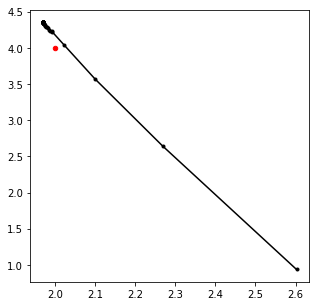

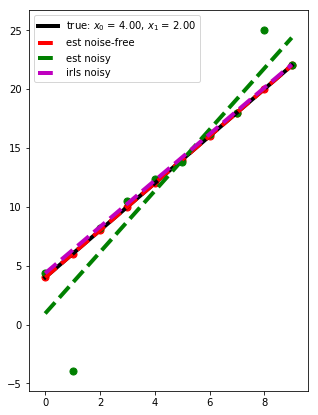

In [12]:
# parameters
N = 10
x = np.array([4., 2.])
sigma = 0.2

# set up problem
t = np.arange(N, dtype='float64')
LRop = LinearRegression(t, dtype='float64')
dottest(LRop, N, 2, verb=True)

y = LRop*x
np.random.seed(0)
yn = y + np.random.normal(0, sigma, N)

# add outliers
yn[1]-=10
yn[N-2]+=5

# inversion
nouter = 100
epsR=1e-2
epspinv=0


xest = LRop / y
xnest = LRop / yn
xirlsest, nouter, xirlsest_hist, rw_hist = IRLSpylops(LRop, yn, nouter, epsR, epspinv, 
                                                      tol=1e-3, returnhistory=True)
xirlsest, nouter, xirlsest_hist, rw_hist = IRLSpylops(LRop, yn, nouter, epsR, epspinv, 
                                                      x0=np.array([-5., 2.]), tol=1e-3, returnhistory=True)

print(x)
print(xest)
print(xnest)
print(xirlsest)
print(xirlsest_hist[0])
print(xirlsest_hist[-1])
print('niter:', xirlsest_hist.shape[0])


plt.figure(figsize=(5,5))
plt.plot(xirlsest_hist[:,1], xirlsest_hist[:,0], '.-k')
plt.scatter(x[1], x[0], c='r', s=20)

plt.figure(figsize=(5, 7))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * x[1] + x[0], 'k', lw=4,
         label=r'true: $x_0$ = %.2f, $x_1$ = %.2f' % (x[0], x[1]))
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * xest[1] + xest[0], '--r', lw=4, label='est noise-free')
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * xnest[1] + xnest[0], '--g', lw=4, label='est noisy')
plt.plot(np.array([t.min(), t.max()]),
         np.array([t.min(), t.max()]) * xirlsest[1] + xirlsest[0], '--m', lw=4, label='irls noisy')
plt.scatter(t, y, c='r', s=50)
plt.scatter(t, yn, c='g', s=50)
plt.legend()

# Polynomial regression

Dot test passed, v^T(Opu)=-722.830915 - u^T(Op^Tv)=-722.830915
x= [1. 2. 2. 3.]
lsqr solution xest= [1. 2. 2. 3.]


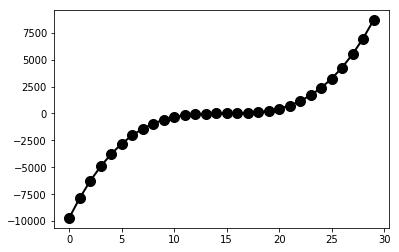

In [13]:
# parameters
order = 3
N = 30
x = np.array([1., 2., 2., 3.])

# set up problem
t = np.arange(N, dtype=np.float64)-N//2
LRop = Regression(t, order=order, dtype='float64')
dottest(LRop, N, order+1, verb=True)

y = LRop*x

plt.figure()
plt.plot(y, '.-k', ms=20, lw=2)

# LSQR solver
xlsqr, istop, itn, r1norm, r2norm = lsqr(LRop, y, damp=1e-10, iter_lim=10 ,show=0)[0:5]
xlsqr = LRop / y

print('x=',x)
print('lsqr solution xest=', xlsqr)

# Matrix Multiplication

Create operator simply overloading a numpy matrix $\mathbf{A}$

$$\mathbf{y}=  \mathbf{A} \mathbf{x}$$

In [14]:
ny,nx=4, 4
G = np.random.normal(0,1,(ny,nx))
x = np.ones(nx)

Gop = MatrixMult(G, dtype='float64')
dottest(Gop,ny,nx)

print('eigs=',Gop.eigs())
print('Ginv=',Gop.inv())

y=Gop*x
print('y=',y)

xest = Gop/y
xlsqr, istop, itn, r1norm, r2norm = lsqr(Gop, y, damp=1e-10, iter_lim=100, show=0)[0:5]

print('x=',x)
print('direct inversion xest=', xest)
print('lsqr solution xest=', xlsqr)

eigs= [ 0.75998016+0.69197126j  0.75998016-0.69197126j -0.48741587+0.j
 -2.14586031+0.j        ]
Ginv= [[ 0.45302694 -0.75988473  0.01426616  0.17735354]
 [ 0.17060196  0.277063   -1.13385171 -0.67769281]
 [-0.43271974  0.12907278 -0.09325337 -0.89992607]
 [ 0.98202276 -0.13402219 -0.77977547 -1.71566681]]
y= [-1.42303149 -2.33520219 -1.29128768 -0.62807414]
x= [1. 1. 1. 1.]
direct inversion xest= [1. 1. 1. 1.]
lsqr solution xest= [1. 1. 1. 1.]


The same matrix can be applied to multiple columns of x, equivalent to

$$  \mathbf{y} =
    \begin{bmatrix}
    \mathbf{A}  \quad \mathbf{0}  \quad  \mathbf{0}  \\
    \mathbf{0}  \quad \mathbf{A}  \quad  \mathbf{0}  \\
    \mathbf{0}  \quad \mathbf{0}  \quad  \mathbf{A}
    \end{bmatrix} 
    \begin{bmatrix}
    \mathbf{x_1}  \\
    \mathbf{x_2}  \\
    \mathbf{x_3}  
    \end{bmatrix}$$
   

In [15]:
G = np.array([[1,2],[4,5]])
x = np.array([[1,1],[2,2]]).flatten()

Gop = MatrixMult(G, dims=[2], dtype='int32')
dottest(Gop,4,4)
y=Gop*x

xlsqr, istop, itn, r1norm, r2norm = lsqr(Gop, y, damp=1e-10, iter_lim=10 ,show=0)[0:5]

print('x=',x)
print('lsqr solution xest=', xlsqr)

x= [1 1 2 2]
lsqr solution xest= [1. 1. 2. 2.]


In [16]:
x = np.random.normal(0,1,(2,4,3)).flatten()

Gop = MatrixMult(G,dims=[4,3], dtype='float64')
dottest(Gop,24,24)

y=Gop*x
print('y=',y)

xlsqr, istop, itn, r1norm, r2norm = lsqr(Gop, y, damp=1e-10, iter_lim=10 ,show=0)[0:5]

print('x=',x)
print('lsqr solution xest=', xlsqr)
print('lsqr error=', x-xlsqr)

y= [-3.01230239  1.53005379 -1.11790643  2.50105548 -0.74859988  2.85410456
  1.17839523 -0.12309735  1.50925224  5.46763016  1.43260376  0.62405389
 -8.8369517   2.95685998 -3.26209486  6.33688672 -3.61922447  8.48650113
  3.64448174 -2.6121089   6.00550888 16.51290917  5.34967875  1.29024747]
x= [-0.87079715 -0.57884966 -0.31155253  0.05616534 -1.16514984  0.90082649
  0.46566244 -1.53624369  1.48825219  1.89588918  1.17877957 -0.17992484
 -1.07075262  1.05445173 -0.40317695  1.22244507  0.20827498  0.97663904
  0.3563664   0.70657317  0.01050002  1.78587049  0.12691209  0.40198936]
lsqr solution xest= [-0.87079715 -0.57884966 -0.31155253  0.05616534 -1.16514984  0.90082649
  0.46566244 -1.53624369  1.48825219  1.89588918  1.17877957 -0.17992484
 -1.07075262  1.05445173 -0.40317695  1.22244507  0.20827498  0.97663904
  0.3563664   0.70657317  0.01050002  1.78587049  0.12691209  0.40198936]
lsqr error= [ 6.65023592e-14 -2.95319325e-14  1.62092562e-14 -3.63181707e-14
  2.42028619e-14 -

Finally we consider the case of a scipy sparse matrix

In [17]:
ny,nx = 4, 4
G = rand(ny,nx, density=0.75)
print(G.todense())
x = np.ones(nx)

Gop = MatrixMult(G, dtype='float64')
dottest(Gop,ny,nx)

print('eigs=',Gop.eigs())
print('Ginv=',Gop.inv())

y=Gop*x
print('y=',y)

xest = Gop/y
xlsqr, istop, itn, r1norm, r2norm = lsqr(Gop, y, damp=1e-10, iter_lim=100, show=0)[0:5]

print('x=',x)
print('direct inversion xest=', xest)
print('lsqr solution xest=', xlsqr)

[[0.31179588 0.         0.17960368 0.53657921]
 [0.69634349 0.21689698 0.06724963 0.        ]
 [0.         0.02467873 0.89667129 0.37775184]
 [0.67939277 0.45369684 0.99033895 0.        ]]
eigs= [1.39163704+0.j 0.56122657+0.j]
Ginv=   (0, 0)	-1.7653152881355203
  (1, 0)	6.168163519313824
  (2, 0)	-1.614733904908223
  (3, 0)	3.4299319592736226
  (0, 1)	4.42225825650117
  (1, 1)	-10.077960652702014
  (2, 1)	1.5831838683120703
  (3, 1)	-3.0996123667497515
  (0, 2)	2.5075496295135538
  (1, 2)	-8.761594176171336
  (2, 2)	2.293655661528918
  (3, 2)	-2.224820894155638
  (0, 3)	-2.2505283617302605
  (1, 3)	7.498628915383788
  (2, 3)	-0.8816290363903972
  (3, 3)	1.602837521230836
y= [1.02797877 0.9804901  1.29910186 2.12342857]
x= [1. 1. 1. 1.]
direct inversion xest= [1. 1. 1. 1.]
lsqr solution xest= [1. 1. 1. 1.]


/Users/matteoravasi/anaconda/envs/pylops/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/Users/matteoravasi/anaconda/envs/pylops/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)
/Users/matteoravasi/anaconda/envs/pylops/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


# Diagonal

We can also perform an element wise multiplation between the input array $\mathbf{x}$ and another array $\mathbf{d}$:

$$y_i = d_i x_i  \quad \forall i=1,2,...,N$$

This is equivalent to a matrix-vector multiplication with a matrix containing the vector $\mathbf{d}$ along its main diagonal.

In [18]:
x   = np.ones(10)
d   = np.arange(10)
Dop = Diagonal(d)
dottest(Dop,10,10,verb=True)

y  = Dop*x
y1 = Dop.H*x

print('D*x  = ',y)
print('D\'*x = ',y1)

Dot test passed, v^T(Opu)=2.814420 - u^T(Op^Tv)=2.814420
D*x  =  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
D'*x =  [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Similarly in 2d

In [19]:
x   = np.ones((3,5))
d   = np.ones(15).reshape(3,5)
d[1:] = 0   
Dop = Diagonal(d)
dottest(Dop,15,15,verb=True)

y  = Dop*x.flatten()
y1 = Dop.H*x.flatten()

print('D*x  = ',y.reshape(3,5))
print('D\'*x = ',y1.reshape(3,5))

Dot test passed, v^T(Opu)=-0.260658 - u^T(Op^Tv)=-0.260658
D*x  =  [[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
D'*x =  [[1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


# Identity

Apply identity operator. The forward is
$$\mathbf{y} = \mathbf{I}\mathbf{x}=\mathbf{x}$$

and the adjoint is
$$\mathbf{x} = \mathbf{I}\mathbf{y}=\mathbf{y}$$

In [20]:
ny, nx = 5, 5 
x   = np.arange(nx)
Iop = Identity(ny, nx)
dottest(Iop, ny, nx, verb=True)

y  = Iop*x
y1 = Iop.H*x

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=-0.195942 - u^T(Op^Tv)=-0.195942
x  =  [0 1 2 3 4]
I*x  =  [0 1 2 3 4]
I'*x =  [0 1 2 3 4]


Let's be aware of the fact that Identity does not copy the input but just makes a reference

In [21]:
y[2] = 100
print(x, y)

[  0   1 100   3   4] [  0   1 100   3   4]


In some cases this may be what you want as the Identity operator is part of a bigger chained operator and y is added to something (or further manipulated) and the reference is gone

In [22]:
x   = np.arange(nx)
y = Iop * x
y = y + 10*np.ones_like(y)
print(x, y)

[0 1 2 3 4] [10 11 12 13 14]


Nevertheless, if its important to ensure that x and y are not reference to each other, use inplace=False

In [23]:
Iop = Identity(ny, nx, inplace=False)

x   = np.arange(nx)
y = Iop * x
x[2] = 100
print(x, y)

[  0   1 100   3   4] [0 1 2 3 4]


Identity can also be used when model and data have different size. It will apply truncation when moving from bigger to smaller array and zero padding when moving from smaller to bigger array.

In [24]:
ny, nx = 5, 7
x   = np.arange(nx)
Iop = Identity(ny, nx)
dottest(Iop, ny, nx, verb=True)

y  = Iop*x
y1 = Iop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=-0.722204 - u^T(Op^Tv)=-0.722204
x  =  [0 1 2 3 4 5 6]
I*x  =  [0 1 2 3 4]
I'*x =  [0. 1. 2. 3. 4. 0. 0.]


Same here, note that if you do not choose inplace=False, modifying x will modify y

In [25]:
y[2] = 100
print(x, y)

[  0   1 100   3   4   5   6] [  0   1 100   3   4]


In [26]:
x   = np.arange(nx)
Iop = Identity(ny, nx, inplace=False)

y  = Iop*x
y[2] = 100
print(x, y)

[0 1 2 3 4 5 6] [  0   1 100   3   4]


Finally, the other way around

In [27]:
ny, nx = 7, 5 
x   = np.arange(nx)
Iop = Identity(ny, nx)
dottest(Iop, ny, nx, verb=True)

y  = Iop*x
y1 = Iop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=-0.670676 - u^T(Op^Tv)=-0.670676
x  =  [0 1 2 3 4]
I*x  =  [0. 1. 2. 3. 4. 0. 0.]
I'*x =  [0. 1. 2. 3. 4.]


In [28]:
y[2] = 100
print(x, y)

[0 1 2 3 4] [  0.   1. 100.   3.   4.   0.   0.]


# Zero

Apply zero operator. The forward is
$$\mathbf{y} = \mathbf{0}\mathbf{x}=\mathbf{0}_{N_y}$$

and the adjoint is
$$\mathbf{x} = \mathbf{0}\mathbf{y}=\mathbf{0}_{N_x}$$

Same number of elements for model and data

In [29]:
ny, nx = 5, 5
x   = np.arange(nx)
Zop = Zero(ny, nx)
dottest(Zop, ny, nx, verb=True)

y  = Zop*x
y1 = Zop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=0.000000 - u^T(Op^Tv)=0.000000
x  =  [0 1 2 3 4]
I*x  =  [0. 0. 0. 0. 0.]
I'*x =  [0. 0. 0. 0. 0.]


Different number of elements for model and data

In [30]:
ny, nx = 7, 5
x   = np.arange(nx)
Zop = Zero(ny, nx)
dottest(Zop, ny, nx, verb=True)

y  = Zop*x
y1 = Zop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=0.000000 - u^T(Op^Tv)=0.000000
x  =  [0 1 2 3 4]
I*x  =  [0. 0. 0. 0. 0. 0. 0.]
I'*x =  [0. 0. 0. 0. 0.]


In [31]:
ny, nx = 5, 7
x   = np.arange(nx)
Zop = Zero(ny, nx)
dottest(Zop, ny, nx, verb=True)

y  = Zop*x
y1 = Zop.H*y

print('x  = ',x)
print('I*x  = ',y)
print('I\'*x = ',y1)

Dot test passed, v^T(Opu)=0.000000 - u^T(Op^Tv)=0.000000
x  =  [0 1 2 3 4 5 6]
I*x  =  [0. 0. 0. 0. 0.]
I'*x =  [0. 0. 0. 0. 0. 0. 0.]


# Sum

Sum a 2-dimensional array along one axis

In [32]:
ny, nx = 5, 7
x   = (np.arange(ny*nx)).reshape(ny, nx)
Sop = Sum(dims=(ny, nx), dir=0)
dottest(Sop, nx, ny*nx, verb=True)

y  = Sop*x.ravel()
xadj = Sop.H*y
xinv = Sop/y

xadj = xadj.reshape(ny, nx)
xinv = xinv.reshape(ny, nx)

print('x  = ',x)
print('S*x  = ',y)
print('S\'*y = ',xadj)
print('S^-1*y = ',xinv)

print('y-S*xadj = ',y-Sop*xadj.ravel())
print('y-S*xinv = ',y-Sop*xinv.ravel())

Dot test passed, v^T(Opu)=8.057575 - u^T(Op^Tv)=8.057575
x  =  [[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]]
S*x  =  [ 70  75  80  85  90  95 100]
S'*y =  [[ 70  75  80  85  90  95 100]
 [ 70  75  80  85  90  95 100]
 [ 70  75  80  85  90  95 100]
 [ 70  75  80  85  90  95 100]
 [ 70  75  80  85  90  95 100]]
S^-1*y =  [[14. 15. 16. 17. 18. 19. 20.]
 [14. 15. 16. 17. 18. 19. 20.]
 [14. 15. 16. 17. 18. 19. 20.]
 [14. 15. 16. 17. 18. 19. 20.]
 [14. 15. 16. 17. 18. 19. 20.]]
y-S*xadj =  [-280 -300 -320 -340 -360 -380 -400]
y-S*xinv =  [-1.42108547e-14 -1.42108547e-14 -1.42108547e-14 -1.42108547e-14
 -1.42108547e-14 -1.42108547e-14 -2.84217094e-14]


We do the same for the other direction

In [33]:
Sop = Sum(dims=(ny, nx), dir=1)
dottest(Sop, ny, ny*nx, verb=True)

y  = Sop*x.ravel()
xadj = Sop.H*y
xadj = xadj.reshape(ny, nx)

print('x  = ',x)
print('S*x  = ',y)
print('S\'*y = ',xadj)

Dot test passed, v^T(Opu)=-1.065695 - u^T(Op^Tv)=-1.065695
x  =  [[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]]
S*x  =  [ 21  70 119 168 217]
S'*y =  [[ 21  21  21  21  21  21  21]
 [ 70  70  70  70  70  70  70]
 [119 119 119 119 119 119 119]
 [168 168 168 168 168 168 168]
 [217 217 217 217 217 217 217]]


Same now for a 3-dimensional array along one axis

In [34]:
ny, nx, nz = 5, 7, 3

Sop = Sum(dims=(ny, nx, nz), dir=0)
dottest(Sop, nx*nz, ny*nx*nz, verb=True)

Sop = Sum(dims=(ny, nx, nz), dir=1)
dottest(Sop, ny*nz, ny*nx*nz, verb=True)

Sop = Sum(dims=(ny, nx, nz), dir=2)
dottest(Sop, ny*nx, ny*nx*nz, verb=True)

Dot test passed, v^T(Opu)=15.420639 - u^T(Op^Tv)=15.420639
Dot test passed, v^T(Opu)=0.927339 - u^T(Op^Tv)=0.927339
Dot test passed, v^T(Opu)=1.505621 - u^T(Op^Tv)=1.505621


True

# Derivatives

## First Derivative


Let's starting comparing two implementations of 1D first derivative: 

1. dense matrix
2. lops

In [35]:
nx = 11
x = np.arange(nx) - (nx-1)/2

In [36]:
D = np.diag(0.5*np.ones(nx-1),k=1) - np.diag(0.5*np.ones(nx-1),-1) 
D[0] = D[-1] = 0

y_dir    = np.dot(D,x)
xadj_dir = np.dot(D.T,y_dir)
xinv_dir = sp.linalg.lstsq(D, y_dir)[0]

Dot test passed, v^T(Opu)=-0.935930 - u^T(Op^Tv)=-0.935929


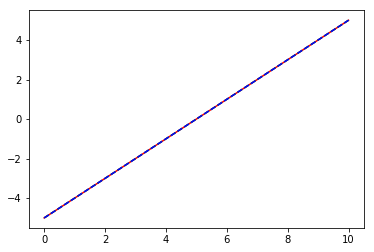

In [37]:
D1op = FirstDerivative(nx, edge=True, dtype='float32')
dottest(D1op,nx,nx, verb=True)

y_lop    = D1op*x
xadj_lop = D1op.H*y_lop

xinv_lop = D1op / y_lop
xinv_lop = lsqr(D1op, y_lop)[0]

plt.figure()
plt.plot(x,'r')
plt.plot(xinv_dir, '--g')
plt.plot(xinv_lop, '--b');

2D First Derivative in 1st direction

Dot test passed, v^T(Opu)=-7.661133 - u^T(Op^Tv)=-7.661133


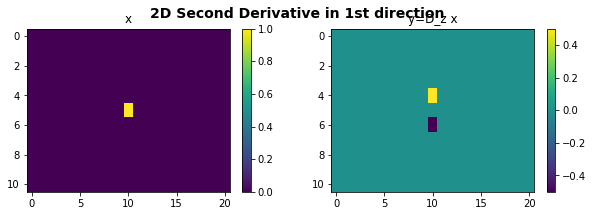

In [38]:
A= np.zeros((11,21))
A[5,10]=1

D2op = FirstDerivative(11*21, dims=[11,21], dir=0, edge=True, dtype='float64')
dottest(D2op,11*21,11*21, verb=True)

B=np.reshape(D2op*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('2D Second Derivative in 1st direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_z x')
plt.colorbar(imh);

2D First Derivative in 2nd direction

Dot test passed, v^T(Opu)=-10.622422 - u^T(Op^Tv)=-10.622422


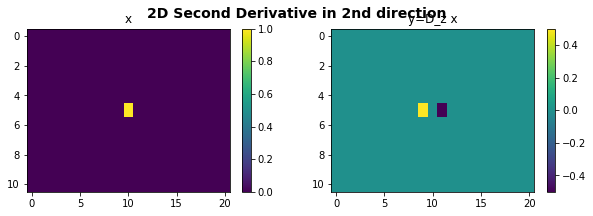

In [39]:
A= np.zeros((11,21))
A[5,10]=1

D2op = FirstDerivative(11*21, dims=[11,21], dir=-1, edge=True, dtype='float64')
dottest(D2op,11*21,11*21, verb=True)

B=np.reshape(D2op*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('2D Second Derivative in 2nd direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_z x')
plt.colorbar(imh);

## Second Derivative

1D Second Derivative



In [40]:
x = (np.arange(11)-5)**2

D2op = SecondDerivative(11, edge=True, dtype='float32')
dottest(D2op, 11,11, verb=True)

y = D2op*x
print(x)
print(y)

Dot test passed, v^T(Opu)=8.598174 - u^T(Op^Tv)=8.598174
[25 16  9  4  1  0  1  4  9 16 25]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


2D Second Derivative in 1st direction

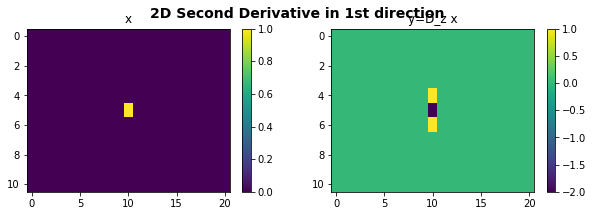

In [41]:
A= np.zeros((11,21))
A[5,10]=1

D2op = SecondDerivative(11*21, dims =[11,21], dir=0, edge=True, dtype='float64')
dottest(D2op,11*21,11*21)

B=np.reshape(D2op*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('2D Second Derivative in 1st direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_z x')
plt.colorbar(imh);

2D Second Derivative in 2nd direction

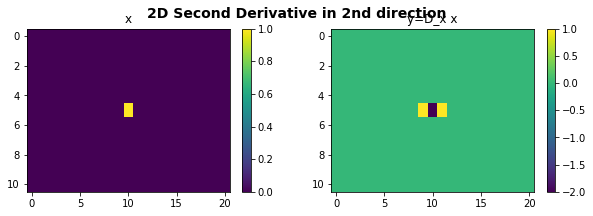

In [42]:
D2op = SecondDerivative(11*21, dims =[11,21], dir=-1, dtype='float64')
dottest(D2op,11*21,11*21)

B=np.reshape(D2op*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('2D Second Derivative in 2nd direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_x x')
plt.colorbar(imh);

3D first derivatives in 3rd direction

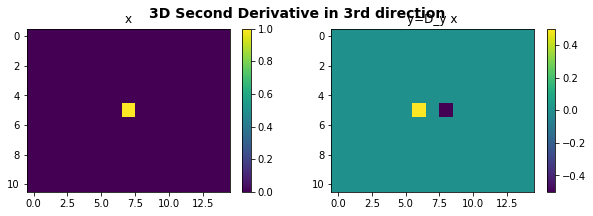

In [43]:
A= np.zeros((11,21,15))
A[5,10,7]=1

D2op = FirstDerivative(11*21*15, dims =[11,21,15], dir=-1, dtype='float64')
dottest(D2op,11*21*15,11*21*15)

B=np.reshape(D2op*np.ndarray.flatten(A),(11,21,15))

fig = plt.figure(figsize=(10,3))
fig.suptitle('3D Second Derivative in 3rd direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A[:,10,:],interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B[:,10,:],interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_y x')
plt.colorbar(imh);

3D first derivatives in 2nd and 3rd direction

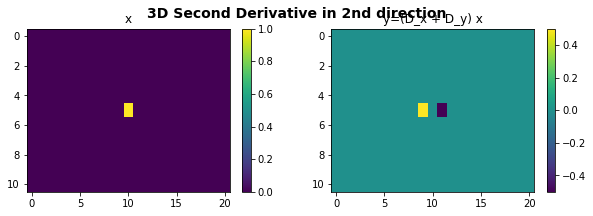

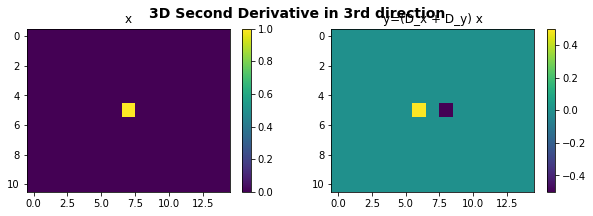

In [44]:
A= np.zeros((11,21,15))
A[5,10,7]=1

D2op = FirstDerivative(11*21*15, dims =[11,21,15], dir=1, dtype='float64') + \
       FirstDerivative(11*21*15, dims =[11,21,15], dir=2, dtype='float64')
dottest(D2op,11*21*15,11*21*15)

B=np.reshape(D2op*np.ndarray.flatten(A),(11,21,15))

fig = plt.figure(figsize=(10,3))
fig.suptitle('3D Second Derivative in 2nd direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A[:,:,7],interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B[:,:,7],interpolation='nearest')
ax.axis('tight')
ax.set_title('y=(D_x + D_y) x')
plt.colorbar(imh)

fig = plt.figure(figsize=(10,3))
fig.suptitle('3D Second Derivative in 3rd direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A[:,10,:],interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B[:,10,:],interpolation='nearest')
ax.axis('tight')
ax.set_title('y=(D_x + D_y) x')
plt.colorbar(imh);

## Laplacian

Symmetrical Laplacian

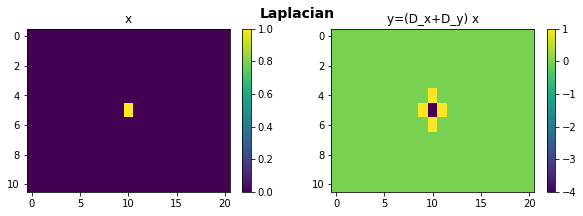

In [45]:
A= np.zeros((11,21))
A[5,10]=1

L2op = Laplacian([11,21], weights=[1,1], edge=True, dtype='float64')
dottest(L2op,11*21,11*21)

B=np.reshape(L2op*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Laplacian',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=(D_x+D_y) x')
plt.colorbar(imh);

Asymmetrical Laplacian

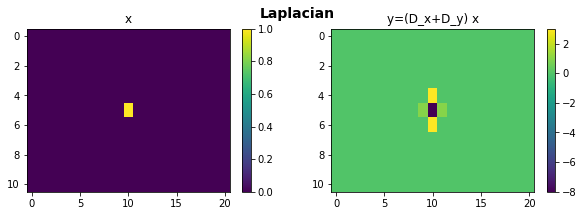

In [46]:
L2op = Laplacian([11,21], weights=[3,1], edge=True, dtype='float32')
dottest(L2op,11*21,11*21)

B=np.reshape(L2op*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Laplacian',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=(D_x+D_y) x')
plt.colorbar(imh);

## Gradient

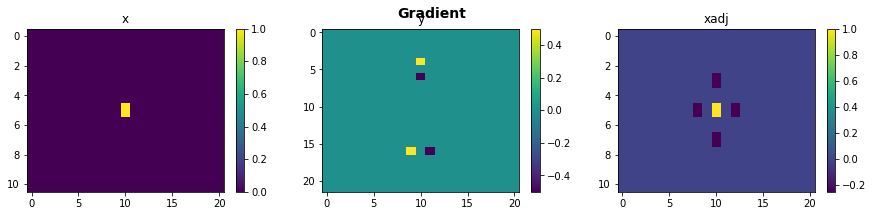

In [47]:
A= np.zeros((11,21))
A[5,10]=1

G2op = Gradient([11,21], edge=True, dtype='float64')
dottest(G2op,11*21*2,11*21)

B=np.reshape(G2op*np.ndarray.flatten(A),(2*11,21))
C=np.reshape(G2op.H*np.ndarray.flatten(B),(11,21))

fig = plt.figure(figsize=(15,3))
fig.suptitle('Gradient',fontsize=14, fontweight='bold')
ax = plt.subplot(1,3,1)
imh = ax.imshow(A, interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,3,2)
imh = ax.imshow(B, interpolation='nearest')
ax.axis('tight')
ax.set_title('y')
plt.colorbar(imh)
ax = plt.subplot(1,3,3)
imh = ax.imshow(C, interpolation='nearest')
ax.axis('tight')
ax.set_title('xadj')
plt.colorbar(imh);

# Smoothing

Derivative (or roughening) operators are generally used as *regularization* in inverse problems. Smoothing is the inverse of roughening and it is employed as *preconditioning* in inverse problems. 

A smoothing operator is a simple compact filter on lenght $N_s$ and each elements is equal to $1/N_s$.

Smoothing of 1d sigal

Dot test passed, v^T(Opu)=-0.087652 - u^T(Op^Tv)=-0.087652


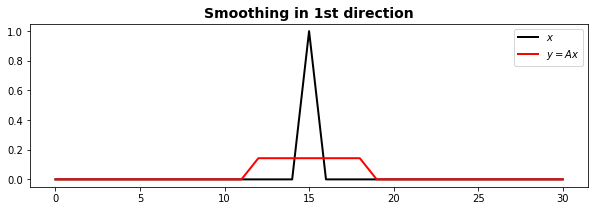

In [48]:
nx = 31
x  = np.zeros(nx)
x[int(nx/2)]=1

Sop = Smoothing1D(nsmooth=7, dims=[nx], dtype='float32')
dottest(Sop, nx, nx, verb=True)

y    = Sop*x
xadj = Sop.H*y

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(x,'k'      ,lw=2, label=r'$x$')
ax.plot(y,'r'      ,lw=2, label=r'$y=Ax$')
ax.set_title('Smoothing in 1st direction',fontsize=14, fontweight='bold')
ax.legend();

Dot test passed, v^T(Opu)=-0.886825 - u^T(Op^Tv)=-0.886825


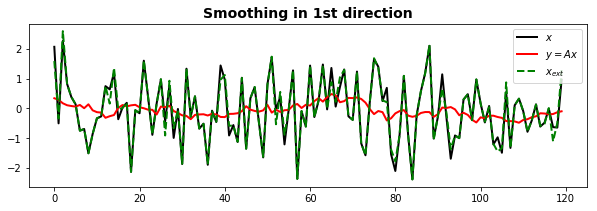

In [49]:
nx = 120
x  = np.random.normal(0,1,nx)

Sop = Smoothing1D(nsmooth=13, dims=[nx], dtype='float32')
dottest(Sop,nx,nx, verb=True)

y    = Sop*x

xlsqr, istop, itn, r1norm, r2norm = lsqr(Sop, y, damp=1e-10, iter_lim=100 ,show=0)[0:5]


fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(x,'k'      ,lw=2, label=r'$x$')
ax.plot(y,'r'      ,lw=2, label=r'$y=Ax$')
ax.plot(xlsqr,'--g',lw=2, label=r'$x_{ext}$')
ax.set_title('Smoothing in 1st direction',fontsize=14, fontweight='bold')
ax.legend();

Smoothing of 2d signal on 1st dimension

Dot test passed, v^T(Opu)=-0.788594 - u^T(Op^Tv)=-0.788594


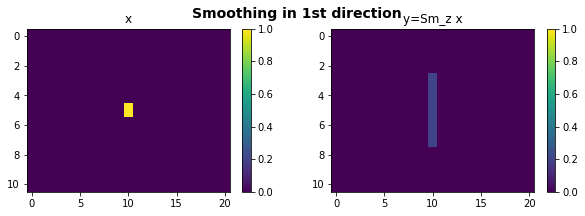

In [50]:
A= np.zeros((11,21))
A[5,10]=1

Sop = Smoothing1D(nsmooth=5, dims=[11,21], dir=0,  dtype='float64')
dottest(Sop,11*21,11*21, verb=True)

B=np.reshape(Sop*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Smoothing in 1st direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest', vmin=0, vmax=1)
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest', vmin=0, vmax=1)
ax.axis('tight')
ax.set_title('y=Sm_z x')
plt.colorbar(imh);

Smoothing of 2d signal on both dimensions

Dot test passed, v^T(Opu)=7.099269 - u^T(Op^Tv)=7.099269


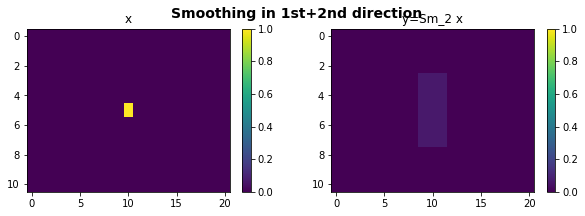

In [51]:
A= np.zeros((11,21))
A[5,10]=1

Sop = Smoothing2D(nsmooth=[5,3], dims=[11,21], dtype='float64') 
dottest(Sop,11*21,11*21, verb=True)

B=np.reshape(Sop*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Smoothing in 1st+2nd direction',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest', vmin=0, vmax=1)
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest', vmin=0, vmax=1)
ax.axis('tight')
ax.set_title('y=Sm_2 x')
plt.colorbar(imh);

# Concatenation of linear operators

We now want to concatenate various operators

$$\mathbf{D}=  \mathbf{D_v} \mathbf{D_h}$$

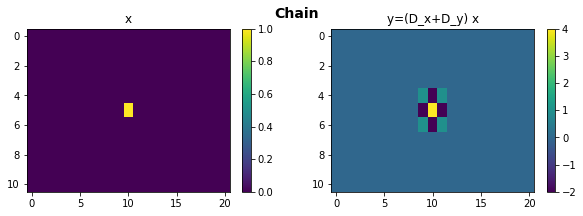

In [52]:
A= np.zeros((11,21))
A[5,10]=1

D2hop = SecondDerivative(11*21, dims =[11,21], dir=1, dtype='float32')
D2vop = SecondDerivative(11*21, dims =[11,21], dir=0, dtype='float32')

D2op = D2vop*D2hop
dottest(D2op,11*21,11*21)

B=np.reshape(D2op*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Chain',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=(D_x+D_y) x')
plt.colorbar(imh);

## Vertical stacking of operators

We now want to vertically stack 2 operators

$$  \mathbf{D} =
    \begin{bmatrix}
    \mathbf{D_v}    \\
    \mathbf{D_h}    
    \end{bmatrix}$$

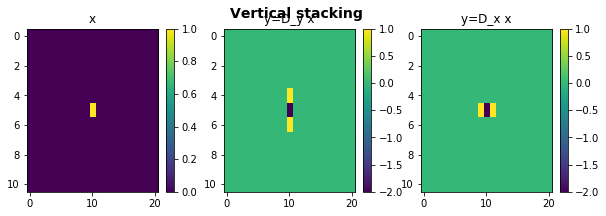

In [53]:
D2hop = SecondDerivative(11*21, dims =[11,21], dir=1, dtype='float64')
D2vop = SecondDerivative(11*21, dims =[11,21], dir=0, dtype='float64')

Vstackop = VStack([D2vop,D2hop])
dottest(Vstackop,2*11*21,11*21)

B=np.reshape(Vstackop*np.ndarray.flatten(A),(11*2,21))
B1 = B[0:11]
B2 = B[11:]

fig = plt.figure(figsize=(10,3))
fig.suptitle('Vertical stacking',fontsize=14, fontweight='bold')
ax = plt.subplot(1,3,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,3,2)
imh = ax.imshow(B1,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_y x')
plt.colorbar(imh)
ax = plt.subplot(1,3,3)
imh = ax.imshow(B2,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_x x')
plt.colorbar(imh);

and three operators

$$  \mathbf{D} =
    \begin{bmatrix}
    \mathbf{D_v}    \\
    0.5*\mathbf{D_h}    \\
    2*\mathbf{D_v}    
    \end{bmatrix}$$

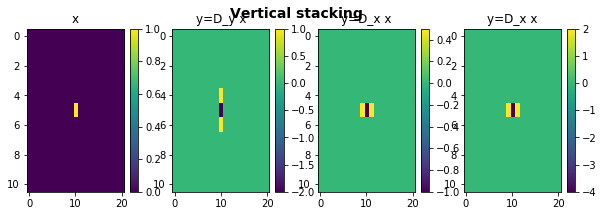

In [54]:
D2hop = SecondDerivative(11*21, dims =[11,21], dir=1, dtype='float64')
D2vop = SecondDerivative(11*21, dims =[11,21], dir=0, dtype='float64')

Vstackop = VStack([D2vop,0.5*D2hop,2*D2hop])
dottest(Vstackop,3*11*21,11*21)

B=np.reshape(Vstackop*np.ndarray.flatten(A),(11*3,21))
B1 = B[0:11]
B2 = B[11:22]
B3 = B[22:]

fig = plt.figure(figsize=(10,3))
fig.suptitle('Vertical stacking',fontsize=14, fontweight='bold')
ax = plt.subplot(1,4,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,4,2)
imh = ax.imshow(B1,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_y x')
plt.colorbar(imh)
ax = plt.subplot(1,4,3)
imh = ax.imshow(B2,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_x x')
plt.colorbar(imh)
ax = plt.subplot(1,4,4)
imh = ax.imshow(B3,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=D_x x')
plt.colorbar(imh);

## Horizontal stacking of operators

We now want to horizontally stack various operators

$$  \mathbf{D} =
    \begin{bmatrix}
    \mathbf{D_v}  \quad 0.5*\mathbf{D_v} \quad  -1*\mathbf{D_h}    
    \end{bmatrix}$$

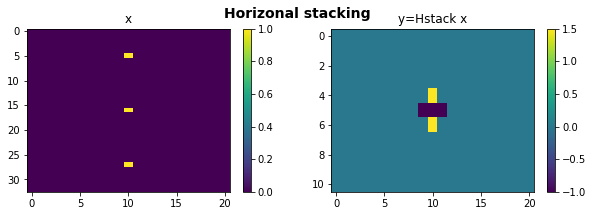

In [55]:
A= np.zeros((11*3,21))
A[5,10]=1
A[5+11,10]=1
A[5+11*2,10]=1

D2hop = SecondDerivative(11*21, dims =[11,21], dir=1, dtype='float64')
D2vop = SecondDerivative(11*21, dims =[11,21], dir=0, dtype='float64')

Hstackop = HStack([D2vop,0.5*D2vop,-1*D2hop])
dottest(Hstackop,11*21,3*11*21)

B=np.reshape(Hstackop*np.ndarray.flatten(A),(11,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Horizonal stacking',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=Hstack x')
plt.colorbar(imh);

## Blockdiagonal matrix

We now want to create a block diagonal matrix

$$  \mathbf{D} =
    \begin{bmatrix}
    \mathbf{D_v}  \quad \mathbf{0}       \quad  \mathbf{0}  \\
    \mathbf{0}    \quad 0.5*\mathbf{D_v} \quad  \mathbf{0}  \\
    \mathbf{0}    \quad \mathbf{0}       \quad  -1*\mathbf{D_h}
    \end{bmatrix}$$

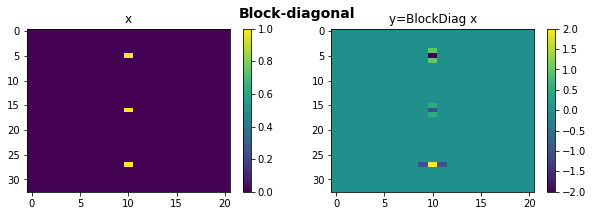

In [56]:
Bop = BlockDiag([D2vop,0.5*D2vop,-1*D2hop])
dottest(Bop,3*11*21,3*11*21)

B=np.reshape(Bop*np.ndarray.flatten(A),(11*3,21))

fig = plt.figure(figsize=(10,3))
fig.suptitle('Block-diagonal',fontsize=14, fontweight='bold')
ax = plt.subplot(1,2,1)
imh = ax.imshow(A,interpolation='nearest')
ax.axis('tight')
ax.set_title('x')
plt.colorbar(imh)
ax = plt.subplot(1,2,2)
imh = ax.imshow(B,interpolation='nearest')
ax.axis('tight')
ax.set_title('y=BlockDiag x')
plt.colorbar(imh);

## Block matrix

In [57]:
bl = Block([[MatrixMult(np.ones((5,5))), -2*Identity(5)],
            [Zero(5),                    Diagonal(-2*np.ones(5))],
            [Identity(5),                Diagonal(-2*np.ones(5), dtype=np.float64)]])
print(bl)
print(bl*np.ones(10))

bl = Block([[Identity(5), Zero(5),     Zero(5)],
            [Zero(5),     2*Identity(5), Zero(5)],
            [Zero(5),     Zero(5),     -1*Identity(5)]])

print(bl)
print(bl*np.ones(15))

<15x10 VStack with dtype=float64>
[ 3.  3.  3.  3.  3. -2. -2. -2. -2. -2. -1. -1. -1. -1. -1.]
<15x15 VStack with dtype=float64>
[ 1.  1.  1.  1.  1.  2.  2.  2.  2.  2. -1. -1. -1. -1. -1.]


# Restriction

Another very useful linear operator is the so-called *restriction* or *sampling* operator. Its forward simply selects a subset of entries from the input vector, while its adjoint places those values at the correct location in the input vector. 

As we will see in the **Optimazion** notebook such operators can be used to interpolate irregularly sampled 1d or 2d signals onto a regular grid

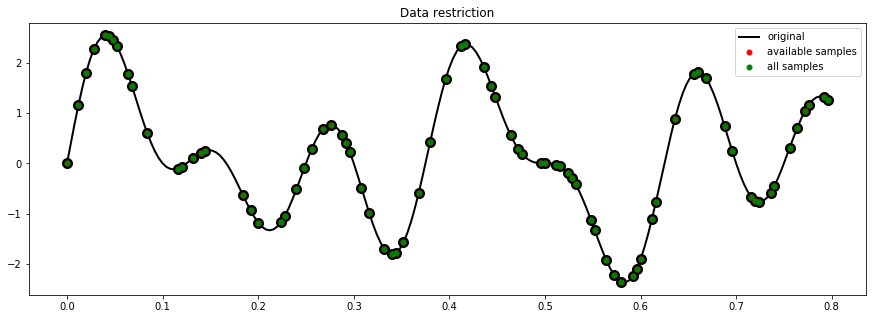

In [58]:
# Signal creation
freqs = [ 5., 3., 8.]

N=200
dt=0.004
t = np.arange(N)*dt
x = np.zeros(N)

for freq in freqs:
    x = x + np.sin(2*np.pi*freq*t)
    
# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N)

y = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,       'k' , LineWidth=2,   label='original')
plt.plot(t[iava], x[iava], '.k', MarkerSize=20)
plt.plot(t[iava], y,       '.r', MarkerSize=10, label='available samples')
plt.plot(t,       ymask,   '.g', MarkerSize=10, label='all samples')
plt.legend()
plt.title('Data restriction');

Same as for Identity, if you dont ask for a copy it will just use reference

In [59]:
x[0] = 100
print(x[:5], y[:5])

[100.           0.40037002   0.79028914   1.15966426   1.49910428] [0.         1.15966426 1.80023773 2.26082239 2.54043067]


But you can avoid doing it in place

In [60]:
Rop = Restriction(N, iava, inplace=False, dtype='float64')
dottest(Rop,Nsub,N)

y = Rop*x
ymask = Rop.mask(x)

x[0] = 100
print(x[:5], y[:5])

[100.           0.40037002   0.79028914   1.15966426   1.49910428] [100.           1.15966426   1.80023773   2.26082239   2.54043067]


# Causal integration

Let's consider the problem of integrating a signal

Dot test passed, v^T(Opu)=4.959918 - u^T(Op^Tv)=4.959918
Dot test passed, v^T(Opu)=2.941969 - u^T(Op^Tv)=2.941969


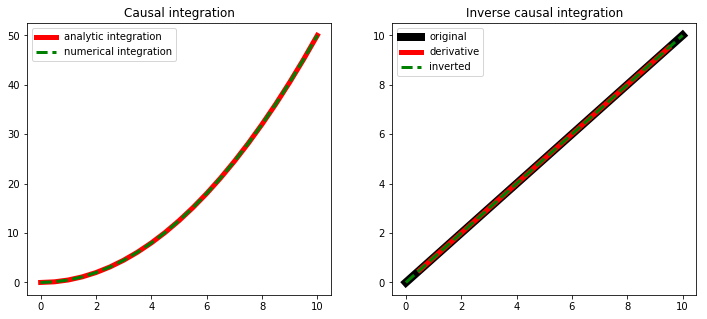

In [61]:
nt = 21
dt = 0.5
ot = 0
t = np.arange(nt)*dt+ot
x = t

Cop = CausalIntegration(nt,sampling=dt, halfcurrent=False)
dottest(Cop,nt,nt, verb=True)

Cop = CausalIntegration(nt,sampling=dt, halfcurrent=True)
dottest(Cop,nt,nt, verb=True)

y    = Cop*x
yana = t**2/2. - t[0]**2/2. + y[0]

xder = np.zeros_like(x)
xder[1:-1] = (y[2:]-y[:-2])/(2*dt)
xinv = Cop / y

# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(t, yana, 'r' , LineWidth=5,   label='analytic integration')
axs[0].plot(t, y, '--g' , LineWidth=3,   label='numerical integration')
axs[0].legend()
axs[0].set_title('Causal integration')

axs[1].plot(t, x, 'k' , LineWidth=8,   label='original')
axs[1].plot(t[1:-1], xder[1:-1], 'r' , LineWidth=5,   label='derivative')
axs[1].plot(t, xinv, '--g' , LineWidth=3,   label='inverted')
axs[1].legend()
axs[1].set_title('Inverse causal integration');

Let's repeat the exercise with a more complicated signal

Dot test passed, v^T(Opu)=7.183853 - u^T(Op^Tv)=7.183853
Dot test passed, v^T(Opu)=-2.753831 - u^T(Op^Tv)=-2.753831


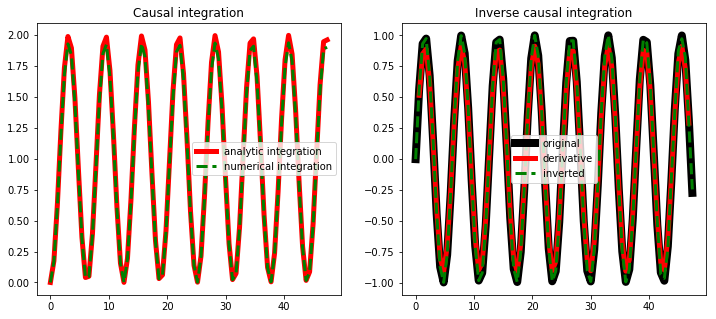

In [62]:
nt = 80
dt = .6
ot = 0
t = np.arange(nt)*dt+ot
x = np.sin(t)

Cop = CausalIntegration(nt,sampling=dt, halfcurrent=False)
dottest(Cop,nt,nt, verb=True)

Cop = CausalIntegration(nt,sampling=dt, halfcurrent=True)
dottest(Cop,nt,nt, verb=True)

yana = -np.cos(t) + np.cos(t[0])
y    = Cop*x

xinv = Cop / y

# Numerical derivative
Dop = FirstDerivative(nt, sampling=dt)
xder = Dop*y

# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(t, yana, 'r' , LineWidth=5,   label='analytic integration')
axs[0].plot(t, y, '--g' , LineWidth=3,   label='numerical integration')
axs[0].legend()
axs[0].set_title('Causal integration')

axs[1].plot(t, x, 'k' , LineWidth=8,   label='original')
axs[1].plot(t[1:-1], xder[1:-1], 'r' , LineWidth=5,   label='derivative')
axs[1].plot(t, xinv, '--g' , LineWidth=3,   label='inverted')
axs[1].legend()
axs[1].set_title('Inverse causal integration');

We can add some noise and compare now the straigh derivative with the inversion of the causalintegration operator

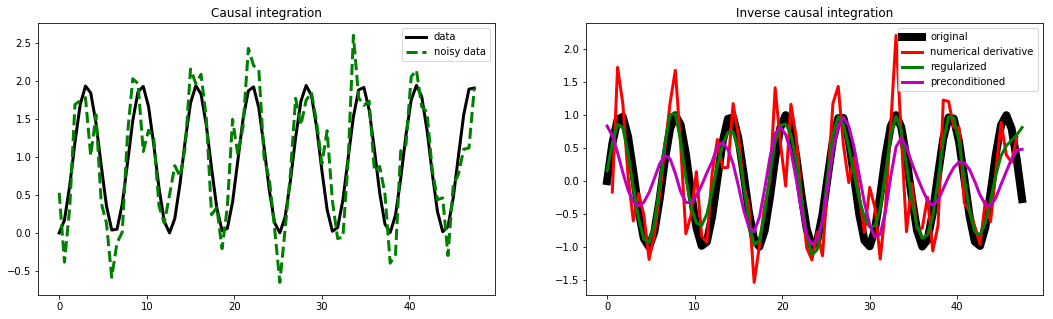

In [63]:
yn = y + np.random.normal(0, 4e-1, y.shape)

# Numerical derivative
Dop = FirstDerivative(nt, sampling=dt)
xder = Dop*yn

# Regularized derivative
Rop = SecondDerivative(nt)
xreg = RegularizedInversion(Cop, [Rop], yn, epsRs=[1e0], **dict(iter_lim=100, atol=1e-5))

# Preconditioned derivative
Sop = Smoothing1D(41, nt)
xp = PreconditionedInversion(Cop, Sop, yn, **dict(iter_lim=50, atol=1e-3))

# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].plot(t, y, 'k' , LineWidth=3,   label='data')
axs[0].plot(t, yn, '--g' , LineWidth=3,   label='noisy data')
axs[0].legend()
axs[0].set_title('Causal integration')

axs[1].plot(t, x, 'k' , LineWidth=8, label='original')
axs[1].plot(t[1:-1], xder[1:-1], 'r', LineWidth=3, label='numerical derivative')
axs[1].plot(t, xreg, 'g' , LineWidth=3,   label='regularized')
axs[1].plot(t, xp, 'm' , LineWidth=3,   label='preconditioned')

axs[1].legend()
axs[1].set_title('Inverse causal integration');

Finally we repeat the same exercise in 2d

Dot test passed, v^T(Opu)=-1.602806 - u^T(Op^Tv)=-1.602806


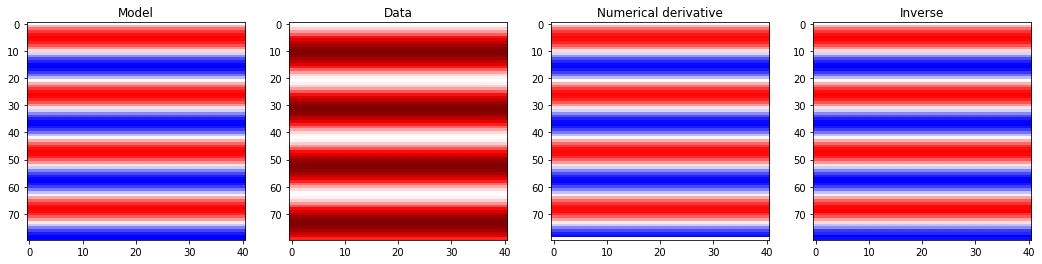

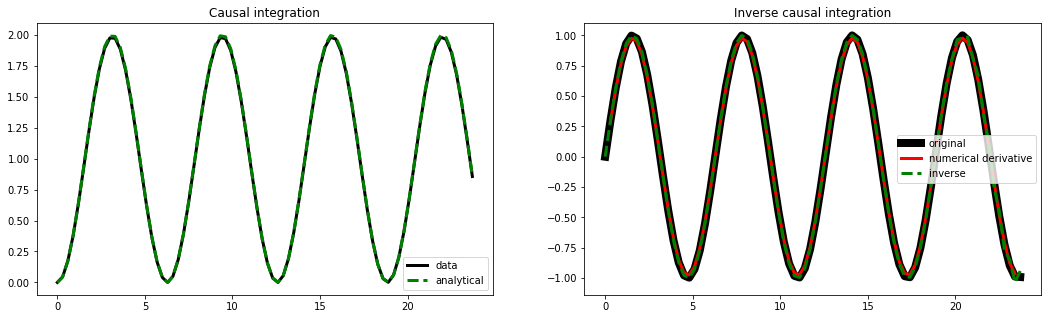

In [64]:
nt, nx = 80, 41
dt = .3
ot = 0
t = np.arange(nt)*dt+ot
x = np.outer(np.sin(t), np.ones(nx))

Cop = CausalIntegration(nt*nx, dims=(nt, nx), sampling=dt, dir=0,  halfcurrent=True)
dottest(Cop, nt*nx, nt*nx, verb=True)

# numerical integration
y = Cop*x.flatten()
y = y.reshape(nt, nx)

#analytical integration 
yana = np.outer(-np.cos(t), np.ones(nx)) + np.cos(t[0])
yana = yana.reshape(nt, nx)

# Numerical derivative
Dop = FirstDerivative(nt*nx, dims=(nt, nx), dir=0, sampling=dt)
xder = Dop*y.flatten()
xder = xder.reshape(nt, nx)

xinv = Cop / y.flatten()
xinv = xinv.reshape(nt, nx)

# Visualize data and inversion
vmax = 2*np.max(np.abs(x))        
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
axs[0].imshow(x, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(y, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[1].set_title('Data')
axs[1].axis('tight')
axs[2].imshow(xder, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[2].set_title('Numerical derivative')
axs[2].axis('tight')
axs[3].imshow(xinv, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[3].set_title('Inverse')
axs[3].axis('tight')


# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].plot(t, y[:, nx//2], 'k' , LineWidth=3,   label='data')
axs[0].plot(t, yana[:, nx//2], '--g' , LineWidth=3,   label='analytical')
axs[0].legend()
axs[0].set_title('Causal integration')
axs[1].plot(t, x[:, nx//2], 'k' , LineWidth=8, label='original')
axs[1].plot(t[1:-1], xder[1:-1, nx//2], 'r', LineWidth=3, label='numerical derivative')
axs[1].plot(t, xinv[:, nx//2], '--g' , LineWidth=3,   label='inverse')
axs[1].legend()
axs[1].set_title('Inverse causal integration');

We now repeat the exercise with noisy input data

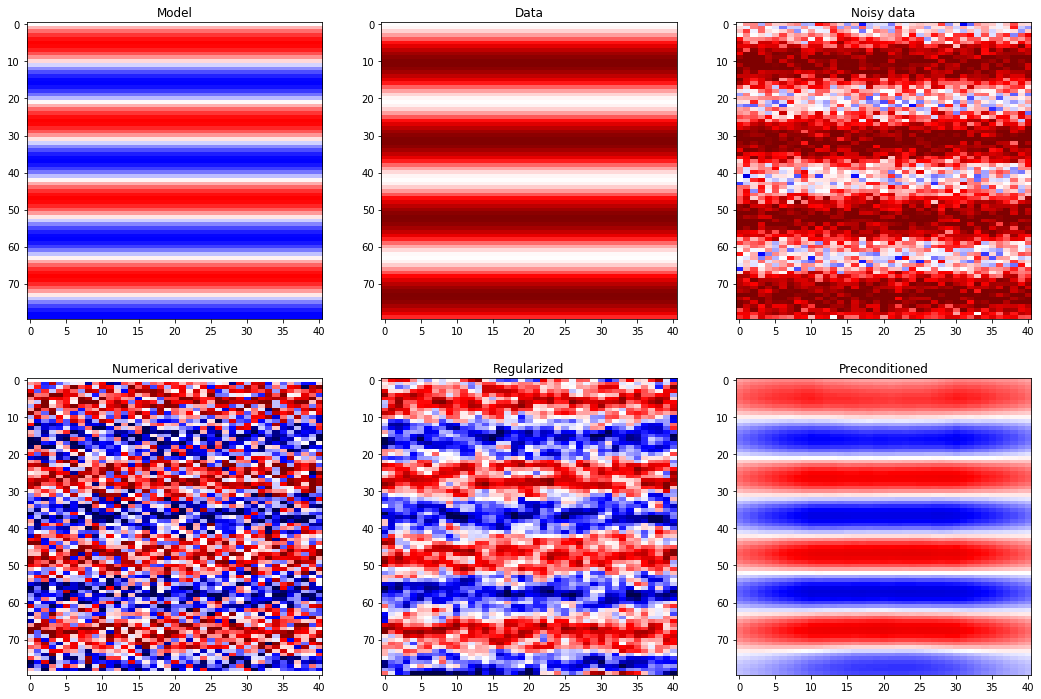

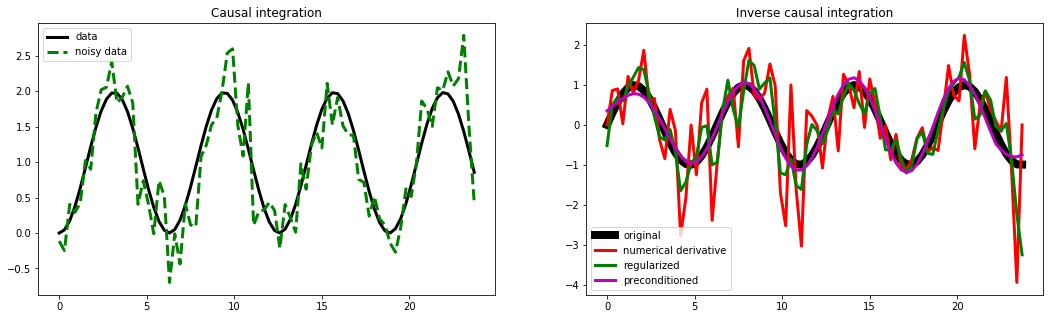

In [65]:
yn = y + np.random.normal(0, 4e-1, y.shape)

# Numerical derivative
Dop = FirstDerivative(nt*nx, dims=(nt, nx), dir=0, sampling=dt)
xder = Dop*yn.flatten()
xder = xder.reshape(nt, nx)

# Regularized derivative
Rop = Laplacian(dims=(nt, nx))
xreg = RegularizedInversion(Cop, [Rop], yn.flatten(), epsRs=[1e-1] )
xreg = xreg.reshape(nt, nx)

# Preconditioned derivative
Sop = Smoothing2D((11, 21), dims=(nt, nx))
xp = PreconditionedInversion(Cop, Sop, yn.flatten(), **dict(iter_lim=50, atol=1e-2))
xp = xp.reshape(nt, nx)


# Visualize data and inversion
vmax = 2*np.max(np.abs(x))        
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[0][0].imshow(x, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[0][0].set_title('Model')
axs[0][0].axis('tight')
axs[0][1].imshow(y, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[0][1].set_title('Data')
axs[0][1].axis('tight')
axs[0][2].imshow(yn, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[0][2].set_title('Noisy data')
axs[0][2].axis('tight')
axs[1][0].imshow(xder, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[1][0].set_title('Numerical derivative')
axs[1][0].axis('tight')
axs[1][1].imshow(xreg, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[1][1].set_title('Regularized')
axs[1][1].axis('tight')
axs[1][2].imshow(xp, cmap='seismic', vmin=-vmax, vmax=vmax)
axs[1][2].set_title('Preconditioned')
axs[1][2].axis('tight')


# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].plot(t, y[:, nx//2], 'k' , LineWidth=3,   label='data')
axs[0].plot(t, yn[:, nx//2], '--g' , LineWidth=3,   label='noisy data')
axs[0].legend()
axs[0].set_title('Causal integration')
axs[1].plot(t, x[:, nx//2], 'k' , LineWidth=8, label='original')
axs[1].plot(t, xder[:, nx//2], 'r', LineWidth=3, label='numerical derivative')
axs[1].plot(t, xreg[:, nx//2], 'g' , LineWidth=3,   label='regularized')
axs[1].plot(t, xp[:, nx//2], 'm' , LineWidth=3,   label='preconditioned')
axs[1].legend()
axs[1].set_title('Inverse causal integration');

And 3d

Dot test passed, v^T(Opu)=-163.709466 - u^T(Op^Tv)=-163.709466


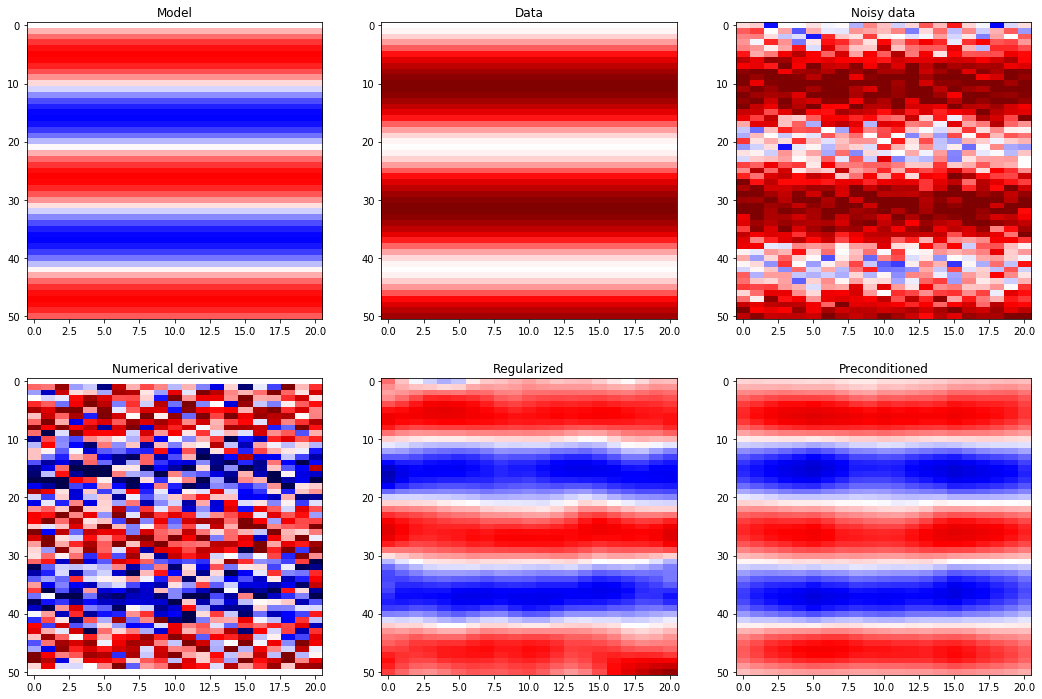

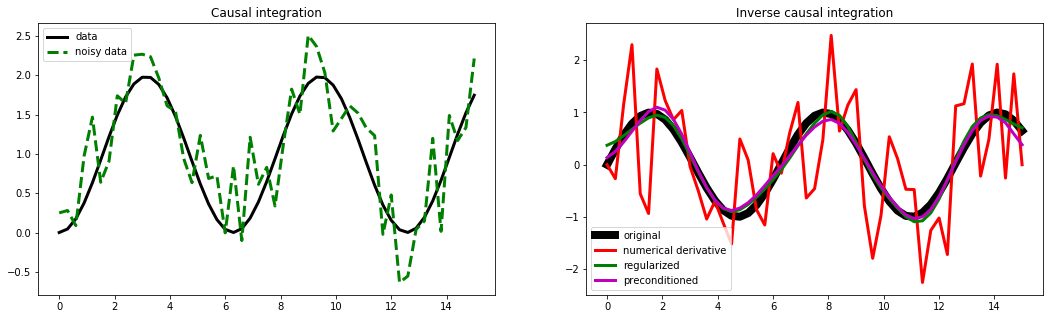

In [66]:
nt, nx, ny = 51, 21, 7
dt = .3
ot = 0
t = np.arange(nt)*dt+ot
x = np.outer(np.sin(t), np.ones(nx))[:, :, np.newaxis] * np.ones(ny)

direction=0
Cop = CausalIntegration(nt*nx*ny, dims=(nt, nx, ny), sampling=dt, dir=direction,  halfcurrent=True)
dottest(Cop, nt*nx*ny, nt*nx*ny, verb=True)


y = Cop*x.flatten()
y = y.reshape(nt, nx, ny)
yn = y + np.random.normal(0, 4e-1, y.shape)

# Numerical derivative
Dop = FirstDerivative(nt*nx*ny, dims=(nt, nx, ny), dir=direction, sampling=dt)
xder = Dop*yn.flatten()
xder = xder.reshape(nt, nx, ny)

# Regularized derivative
Rop = Laplacian(dims=(nt, nx, ny), dirs=(0, 1))
xreg = RegularizedInversion(Cop, [Rop], yn.flatten(), epsRs=[1e0], **dict(iter_lim=100, atol=1e-5))
xreg = xreg.reshape(nt, nx, ny)

# Preconditioned derivative
Sop = Smoothing2D((5, 11), dims=(nt, nx, ny), nodir=2)
xp = PreconditionedInversion(Cop, Sop, yn.flatten(), **dict(iter_lim=20, atol=1e-2))
xp = xp.reshape(nt, nx, ny)

# Visualize data and inversion
vmax = 2*np.max(np.abs(x))        
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[0][0].imshow(x[:, :, ny//2], cmap='seismic', vmin=-vmax, vmax=vmax)
axs[0][0].set_title('Model')
axs[0][0].axis('tight')
axs[0][1].imshow(y[:, :, ny//2], cmap='seismic', vmin=-vmax, vmax=vmax)
axs[0][1].set_title('Data')
axs[0][1].axis('tight')
axs[0][2].imshow(yn[:, :, ny//2], cmap='seismic', vmin=-vmax, vmax=vmax)
axs[0][2].set_title('Noisy data')
axs[0][2].axis('tight')
axs[1][0].imshow(xder[:, :, ny//2], cmap='seismic', vmin=-vmax, vmax=vmax)
axs[1][0].set_title('Numerical derivative')
axs[1][0].axis('tight')
axs[1][1].imshow(xreg[:, :, ny//2], cmap='seismic', vmin=-vmax, vmax=vmax)
axs[1][1].set_title('Regularized')
axs[1][1].axis('tight')
axs[1][2].imshow(xp[:, :, ny//2], cmap='seismic', vmin=-vmax, vmax=vmax)
axs[1][2].set_title('Preconditioned')
axs[1][2].axis('tight')


# Visualize data and inversion
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].plot(t, y[:, nx//2, ny//2], 'k' , LineWidth=3,   label='data')
axs[0].plot(t, yn[:, nx//2, ny//2], '--g' , LineWidth=3,   label='noisy data')
axs[0].legend()
axs[0].set_title('Causal integration')

axs[1].plot(t, x[:, nx//2, ny//2], 'k' , LineWidth=8, label='original')
axs[1].plot(t, xder[:, nx//2, ny//2], 'r', LineWidth=3, label='numerical derivative')
axs[1].plot(t, xreg[:, nx//2, ny//2], 'g' , LineWidth=3,   label='regularized')
axs[1].plot(t, xp[:, nx//2, ny//2], 'm' , LineWidth=3,   label='preconditioned')
axs[1].legend()
axs[1].set_title('Inverse causal integration');

# Flip axis

Dot test passed, v^T(Opu)=-9.197487 - u^T(Op^Tv)=-9.197487


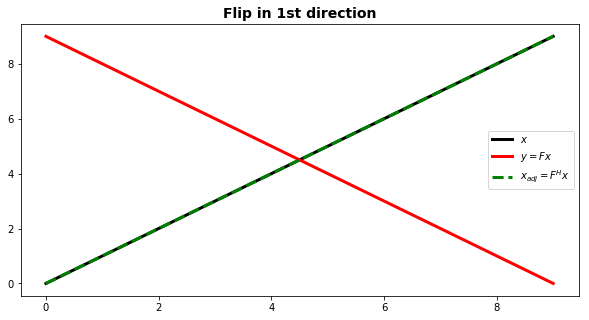

In [67]:
nt = 10
x = np.arange(nt)

Fop = Flip(nt)
dottest(Fop, nt, nt, verb=True)

y = Fop*x
xadj = Fop.H*y

plt.figure(figsize=(10, 5))
plt.plot(x, 'k', lw=3, label=r'$x$')
plt.plot(y, 'r', lw=3, label=r'$y=Fx$')
plt.plot(xadj, '--g', lw=3, label=r'$x_{adj} = F^H x$')
plt.title('Flip in 1st direction', fontsize=14, fontweight='bold')
plt.legend()

Dot test passed, v^T(Opu)=-4.579833 - u^T(Op^Tv)=-4.579833


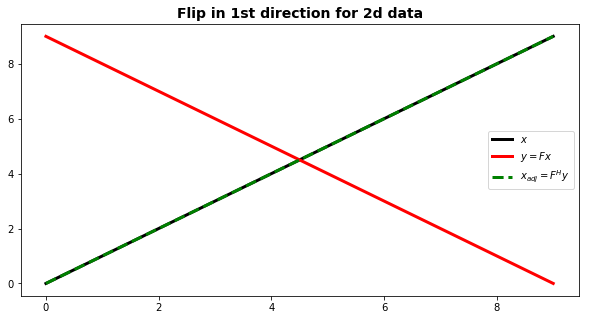

In [68]:
nt, nx = 10, 5
x = np.outer(np.arange(nt), np.ones(nx))

Fop = Flip(nt*nx, dims=(nt, nx), dir=0)
dottest(Fop, nt*nx, nt*nx, verb=True)

y = Fop*x.flatten()
xadj = Fop.H*y.flatten()
y = y.reshape(nt, nx)
xadj = xadj.reshape(nt, nx)


plt.figure(figsize=(10, 5))
plt.plot(x[:, nx//2], 'k', lw=3, label=r'$x$')
plt.plot(y[:, nx//2], 'r', lw=3, label=r'$y=Fx$')
plt.plot(xadj[:, nx//2], '--g', lw=3, label=r'$x_{adj} = F^H y$')
plt.title('Flip in 1st direction for 2d data', fontsize=14, fontweight='bold')
plt.legend();

Dot test passed, v^T(Opu)=-8.976491 - u^T(Op^Tv)=-8.976491


(-0.5, 4.5, 9.5, -0.5)

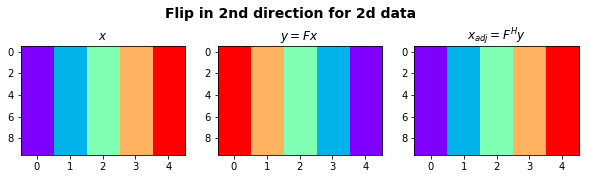

In [69]:
nt, nx = 10, 5
x = np.outer(np.ones(nt), np.arange(nx))

Fop = Flip(nt*nx, dims=(nt, nx), dir=1)
dottest(Fop, nt*nx, nt*nx, verb=True)

y = Fop*x.flatten()
xadj = Fop.H*y.flatten()
y = y.reshape(nt, nx)
xadj = xadj.reshape(nt, nx)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Flip in 2nd direction for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(x, cmap='rainbow')
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(y, cmap='rainbow')
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(xadj, cmap='rainbow')
axs[2].set_title(r'$x_{adj} = F^H y$')
axs[2].axis('tight')

Dot test passed, v^T(Opu)=-0.473327 - u^T(Op^Tv)=-0.473327


(-0.5, 3.5, 2.5, -0.5)

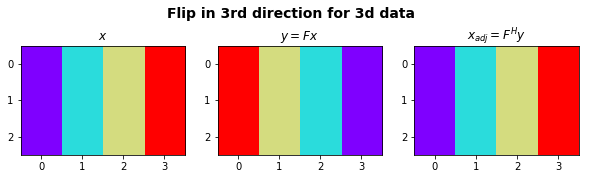

In [70]:
nt, nx, ny = 2, 3, 4
x = np.outer(np.ones(nt), np.ones(nx))[:, :, np.newaxis] * np.arange(ny)

Fop = Flip(nt*nx*ny, dims=(nt, nx, ny), dir=2)
dottest(Fop, nt*nx*ny, nt*nx*ny, verb=True)

y = Fop*x.flatten()
xadj = Fop.H*y.flatten()
y = y.reshape(nt, nx, ny)
xadj = xadj.reshape(nt, nx, ny)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Flip in 3rd direction for 3d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(x[nt//2], cmap='rainbow')
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(y[nt//2], cmap='rainbow')
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(xadj[nt//2], cmap='rainbow')
axs[2].set_title(r'$x_{adj} = F^H y$')
axs[2].axis('tight')

# Symmetrize

Dot test passed, v^T(Opu)=-3.725783 - u^T(Op^Tv)=-3.725783


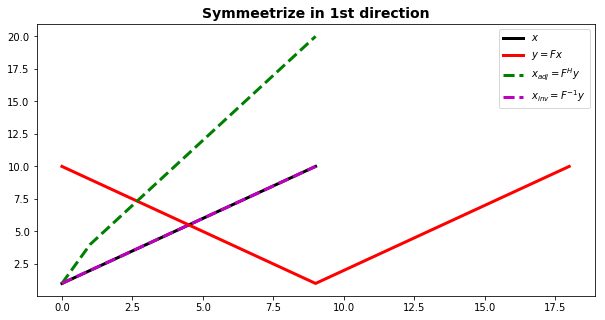

In [71]:
nt = 10
x = np.arange(nt)+1

Sop = Symmetrize(nt)
dottest(Sop, nt*2-1, nt, verb=True)

y = Sop*x
xadj = Sop.H*y
xinv = Sop / y

plt.figure(figsize=(10, 5))
plt.plot(x, 'k', lw=3, label=r'$x$')
plt.plot(y, 'r', lw=3, label=r'$y=Fx$')
plt.plot(xadj, '--g', lw=3, label=r'$x_{adj} = F^H y$')
plt.plot(xinv, '--m', lw=3, label=r'$x_{inv} = F^{-1} y$')
plt.title('Symmeetrize in 1st direction', fontsize=14, fontweight='bold')
plt.legend();

Dot test passed, v^T(Opu)=-7.923517 - u^T(Op^Tv)=-7.923517


(-0.5, 5.5, 9.5, -0.5)

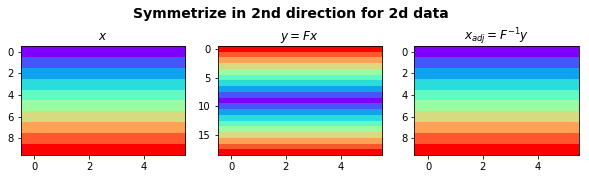

In [72]:
nt, nx = 10, 6
x = np.outer(np.arange(nt), np.ones(nx))

Sop = Symmetrize(nt*nx, dims=(nt, nx), dir=0)
dottest(Sop, (nt*2-1)*nx, nt*nx, verb=True)

y = Sop*x.flatten()
xadj = Sop.H*y.flatten()
xinv = Sop / y
y = y.reshape(2*nt-1, nx)
xadj = xadj.reshape(nt, nx)
xinv = xinv.reshape(nt, nx)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Symmetrize in 2nd direction for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(x, cmap='rainbow', vmin=0, vmax=9)
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(y, cmap='rainbow', vmin=0, vmax=9)
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(xinv, cmap='rainbow', vmin=0, vmax=9)
axs[2].set_title(r'$x_{adj} = F^{-1} y$')
axs[2].axis('tight')

Dot test passed, v^T(Opu)=14.255184 - u^T(Op^Tv)=14.255184


(-0.5, 5.5, 9.5, -0.5)

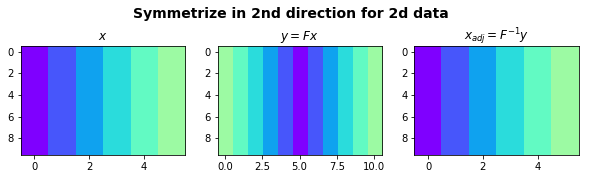

In [73]:
nt, nx = 10, 6
x = np.outer(np.ones(nt), np.arange(nx))

Sop = Symmetrize(nt*nx, dims=(nt, nx), dir=1)
dottest(Sop, nt*(nx*2-1), nt*nx, verb=True)

y = Sop*x.flatten()
xadj = Sop.H*y.flatten()
xinv = Sop / y
y = y.reshape(nt, 2*nx-1)
xadj = xadj.reshape(nt, nx)
xinv = xinv.reshape(nt, nx)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Symmetrize in 2nd direction for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(x, cmap='rainbow', vmin=0, vmax=9)
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(y, cmap='rainbow', vmin=0, vmax=9)
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(xinv, cmap='rainbow', vmin=0, vmax=9)
axs[2].set_title(r'$x_{adj} = F^{-1} y$')
axs[2].axis('tight')

# Transpose

2d

Dot test passed, v^T(Opu)=9.554476 - u^T(Op^Tv)=9.554476


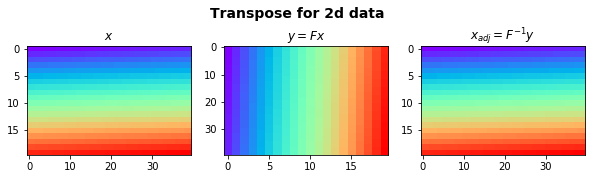

In [74]:
dims = (20, 40)
x = np.arange(800).reshape(dims)

Top = Transpose(dims=dims, axes=(1,0))
dottest(Top, np.prod(dims), np.prod(dims), verb=True)

y = Top * x.ravel()
xadj = Top.H * y
y = y.reshape(Top.dimsd)
xadj = xadj.reshape(Top.dims)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Transpose for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(x, cmap='rainbow', vmin=0, vmax=800)
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(y, cmap='rainbow', vmin=0, vmax=800)
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(xadj, cmap='rainbow', vmin=0, vmax=800)
axs[2].set_title(r'$x_{adj} = F^{-1} y$')
axs[2].axis('tight');

3d

In [75]:
dims = (10, 5, 4)
x = np.arange(np.prod(dims)).reshape(dims)

Top = Transpose(dims=dims, axes=(2, 1, 0))
dottest(Top, np.prod(dims), np.prod(dims), verb=True)

y = Top * x.ravel()
xadj = Top.H * y
y = y.reshape(Top.dimsd)
xadj = xadj.reshape(Top.dims)

print(np.allclose(x, xadj))

Dot test passed, v^T(Opu)=-3.778518 - u^T(Op^Tv)=-3.778518
True


# Kronecker Product

In [76]:
n1, m1 = 10, 5
n2, m2 = 20, 3
A = np.random.normal(0, 1, (n1, m1))
B = 5*np.ones((n2, m2))
x = np.ones(m1*m2)

AB = np.kron(A, B)
y = np.dot(AB, x)
xadj = np.dot(AB.T, y)

Aop = MatrixMult(A)
Bop = MatrixMult(B)

ABop = Kronecker(Aop, Bop)
dottest(ABop, n1*n2, m1*m2, verb=True)

yop = ABop*x
xadjop = ABop.H*yop

xinv = lsqr(AB, y)[0]
xinvop = ABop / yop

print(x)
print(xinv)
print(xinvop)

Dot test passed, v^T(Opu)=346.475936 - u^T(Op^Tv)=346.475936
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Now we use the Kronecker product to apply a second derivative to the second dimension of an array

<231x231 Kronecker with dtype=float64>


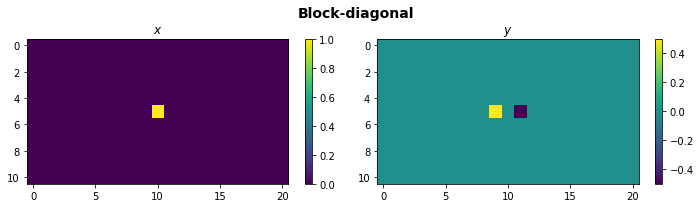

In [77]:
Nv, Nh = 11, 21

Iop = pylops.Identity(Nv, dtype='float32')
D2hop = pylops.FirstDerivative(Nh, dtype='float32')

X = np.zeros((Nv, Nh))
X[Nv//2, Nh//2] = 1
D2hop = Kronecker(Iop, D2hop)
print(D2hop)

Y = D2hop*X.ravel()
Y = Y.reshape(Nv, Nh)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Block-diagonal', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(X, interpolation='nearest')
axs[0].axis('tight')
axs[0].set_title(r'$x$')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(Y, interpolation='nearest')
axs[1].axis('tight')
axs[1].set_title(r'$y$')
plt.colorbar(im, ax=axs[1])
plt.tight_layout()
plt.subplots_adjust(top=0.8)

<231x231 Kronecker with dtype=float64>


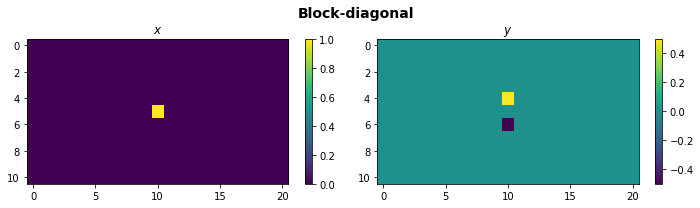

In [78]:
Nv, Nh = 11, 21

Iop = pylops.Identity(Nh, dtype='float32')
D2hop = pylops.FirstDerivative(Nv, dtype='float32')

X = np.zeros((Nv, Nh))
X[Nv//2, Nh//2] = 1
D2hop = Kronecker(D2hop, Iop)
print(D2hop)

Y = D2hop*X.ravel()
Y = Y.reshape(Nv, Nh)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fig.suptitle('Block-diagonal', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(X, interpolation='nearest')
axs[0].axis('tight')
axs[0].set_title(r'$x$')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(Y, interpolation='nearest')
axs[1].axis('tight')
axs[1].set_title(r'$y$')
plt.colorbar(im, ax=axs[1])
plt.tight_layout()
plt.subplots_adjust(top=0.8)

# Pad

1d

In [79]:
dims = 10
pad = (10, 3)

Pop = Pad(dims, pad)
dottest(Pop, dims+pad[0]+pad[1], dims, verb=True)

x = np.arange(dims)+1.

y = Pop*x
xadj = Pop.H*y
xinv = Pop / y

print(x)
print(y)
print(xadj)
print(xinv)

Dot test passed, v^T(Opu)=-3.623419 - u^T(Op^Tv)=-3.623419
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10.  0.  0.  0.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Dot test passed, v^T(Opu)=-3.203188 - u^T(Op^Tv)=-3.203188


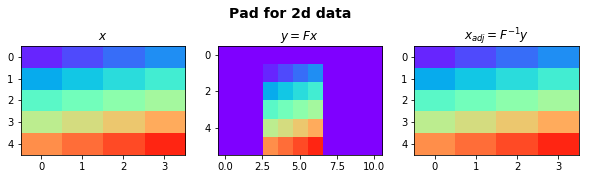

In [80]:
dims = (5, 4)
pad = ((1, 0), (3, 4))

Pop = Pad(dims, pad)
dottest(Pop, Pop.shape[0], Pop.shape[1], verb=True)

x = (np.arange(np.prod(np.array(dims)))+1.).reshape(dims)

y = Pop*x.ravel()
xadj = Pop.H*y
xinv = Pop / y

y = y.reshape(Pop.dimsd)
xadj = xadj.reshape(dims)
xinv = xinv.reshape(dims)

fig, axs = plt.subplots(1, 3, figsize=(10, 2))
fig.suptitle('Pad for 2d data', fontsize=14, fontweight='bold', y=1.15)
axs[0].imshow(x, cmap='rainbow', vmin=0, vmax=np.prod(np.array(dims))+1)
axs[0].set_title(r'$x$')
axs[0].axis('tight')
axs[1].imshow(y, cmap='rainbow', vmin=0, vmax=np.prod(np.array(dims))+1)
axs[1].set_title(r'$y = F x$')
axs[1].axis('tight')
axs[2].imshow(xadj, cmap='rainbow', vmin=0, vmax=np.prod(np.array(dims))+1)
axs[2].set_title(r'$x_{adj} = F^{-1} y$')
axs[2].axis('tight');